In [1]:
import sys
sys.path.append('../')
from aquaculture import *
from deepSolver import *
from fdSolver import *
from jointOptCtrlStopping import *
from deepOS import *

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import hashlib
pltStyles = ['seaborn-v0_8-paper', 'dark_background']
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

dtype = torch.float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [2]:
import IPython
ipython = IPython.get_ipython()
ipython.run_line_magic(magic_name="load_ext", line="autoreload")
ipython.run_line_magic(magic_name="autoreload", line="2") # automatically reload modules before executing user code

# Joint Stochastic Optimal Control and Stopping

## Aquaculture Model

In [3]:
T = 3.0 # time horizon
r = 0.01 # interest rate

# Feeding Curve
f0 = 0.1
# F = LinearFeeding(f0,T)
F = ExpFeeding(f0,T)
ft = F(np.linspace(0, T, 100))

# Host parameters
mu = 0.1
mu_F = 3.0
h0 = 1 # unit host size

hModel = HostConstant(mu, mu_F, F)

# Weight parameters
gamma = 5.0
gamma_F = 10.0
w_inf = 3.0
w0 = 0.01 
nu=0.75

wModel = GrowthConst(gamma, gamma_F, w_inf, F, nu=nu)

# Feed price parameters
sigmaF = 0.25
PF0 = 0.075

pFModel = FeedPriceGBM(r, sigmaF)
pFt = pFModel.simulate(np.linspace(0,T,100), PF0, batch=1024, seed=seed)
# Biomass price parameters
sigmaB = 0.1
PB0 = 0.1

pBModel = BiomassPriceGBM(r, sigmaB)
pBt = pBModel.simulate(np.linspace(0,T,100), PB0, batch=1024,seed=seed+1)

# Grids
N=64
Nt=2048

bnds = [(0.0, T, Nt), # time
        (0.5*w0, 1.1*w_inf, N), # weight
        (0.1*h0, 1.1*h0, N), # host
        (0.1*pFt.min(), 1.5*pFt.max(), N//2), # feed price
        (0.1*pBt.min(), 1.5*pBt.max(), N//2), # biomass price
        (0.0, ft.max(), N)] # control
del pFt, pBt
labels = ["Weight", "Host", "Feed Price", "Biomass Price", "Control", "Value"]
id = hashlib.md5(repr((
    [T,r,f0,mu,mu_F,h0,gamma,gamma_F,w_inf,nu,sigmaF,sigmaB]+
    [np.round(x,9) for b in bnds for x in b]+
    [str(m.__class__.__name__) for m in [pFModel, pBModel, hModel, wModel]]+
    [str(F.__class__.__name__)]
)).encode('utf-8')).hexdigest()

figureSaveDirectory = "../../Figures/Aquaculture/"+ str(id) + "/"
fileSaveDirectory = "../../Data/Aquaculture/"+ str(id) + "/"
Path(figureSaveDirectory).mkdir(parents=True, exist_ok=True)
Path(fileSaveDirectory).mkdir(parents=True, exist_ok=True)
print(bnds)
print("ID: ", id)

[(0.0, 3.0, 2048), (0.005, 3.3000000000000003, 64), (0.1, 1.1, 64), (0.0019001390573845957, 0.38557792417055026, 32), (0.005509022419834892, 0.2635373343778614, 32), (0.0, 1.0000000000000002, 64)]
ID:  64656ea059766c6fa2b2a96e5a115c7c


In [4]:
df=params_to_df([hModel, wModel, pFModel, pBModel,F],initialDatum={"h_0":h0,"w_0":w0,"p^F_0":PF0,"p^B_0":PB0},float_format=".3f").T
df.to_csv(fileSaveDirectory+"params.csv", header=False)
print(df.to_latex(header=False, escape=False))

\begin{tabular}{ll}
\toprule
$h_0$          &     $1.000$ \\
$w_0$          &     $0.010$ \\
$p^F_0$        &     $0.075$ \\
$p^B_0$        &     $0.100$ \\
$\mu_0$        &     $0.100$ \\
$\mu_F$        &     $3.000$ \\
$F$            &  ExpFeeding \\
$\gamma_0$     &     $5.000$ \\
$\gamma_F$     &    $10.000$ \\
$w_{\infty}$   &     $3.000$ \\
$\nu$          &     $0.750$ \\
$r$            &     $0.010$ \\
$\sigma^{p^F}$ &     $0.250$ \\
$\sigma^{p^B}$ &     $0.100$ \\
$f_0$          &     $0.100$ \\
$\lambda$      &     $0.768$ \\
$T$            &     $3.000$ \\
\bottomrule
\end{tabular}



C:\Users\kevin\AppData\Local\Temp\ipykernel_22028\2223737211.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(header=False, escape=False))


## Benchmark


In [5]:
k = lambda t, w, h, pf, pb, u: - h * u * pf
g = lambda t, w, h, pf, pb: w * h * pb
processes = [wModel, hModel, pFModel, pBModel]
d = len(processes)
M = 1024*8

t = torch.linspace(0, T, Nt, dtype=dtype, device=device).reshape(1,-1)
dWt = BrownianMotion(t, M, dim=d, onlyIncrements=True, dtype=dtype, device=device)

benchmark = JointOptCtrlStopping(r, k, g, bnds, processes, CtrlStoppingSolver, {}, device=device, dtype=dtype)
U0 = lambda x: torch.zeros((x.shape[0],1), dtype=dtype, device=device)
Uft = lambda x: F(x[:,0]).reshape(-1,1)
wt = wModel.simulate(t, w0, Uft).detach().cpu()
ht = hModel.simulate(t, h0, Uft).detach().cpu()
tauInd_determ = torch.argmax(wt*ht,axis=1)
tau_determ = t.detach().cpu()[:,tauInd_determ]

(1, 2048)
(1, 2048)


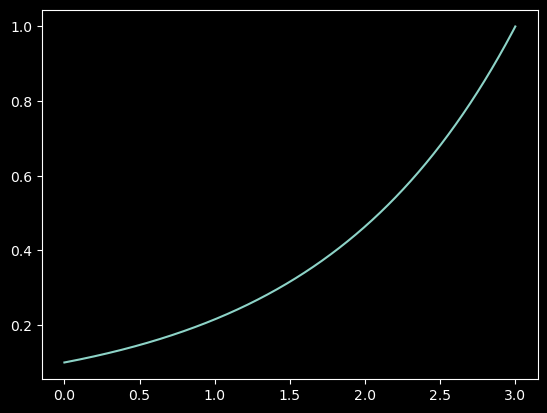

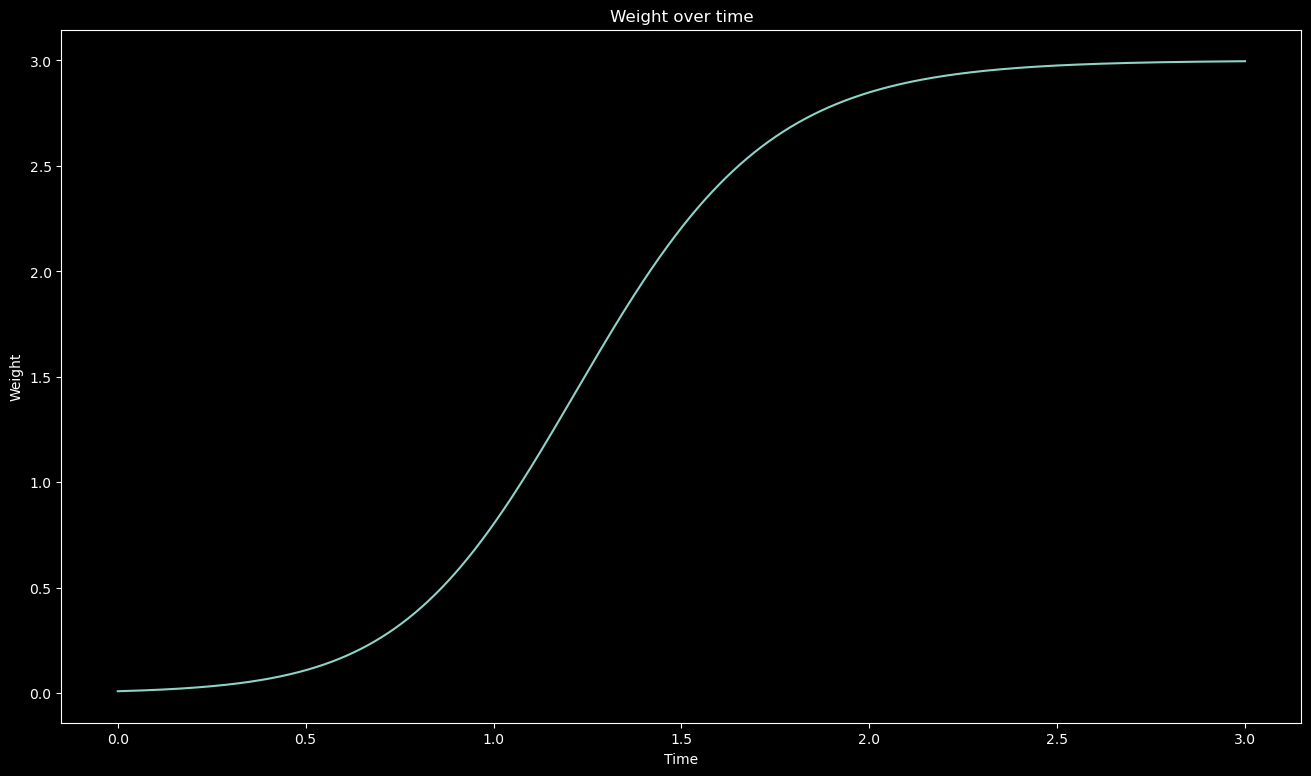

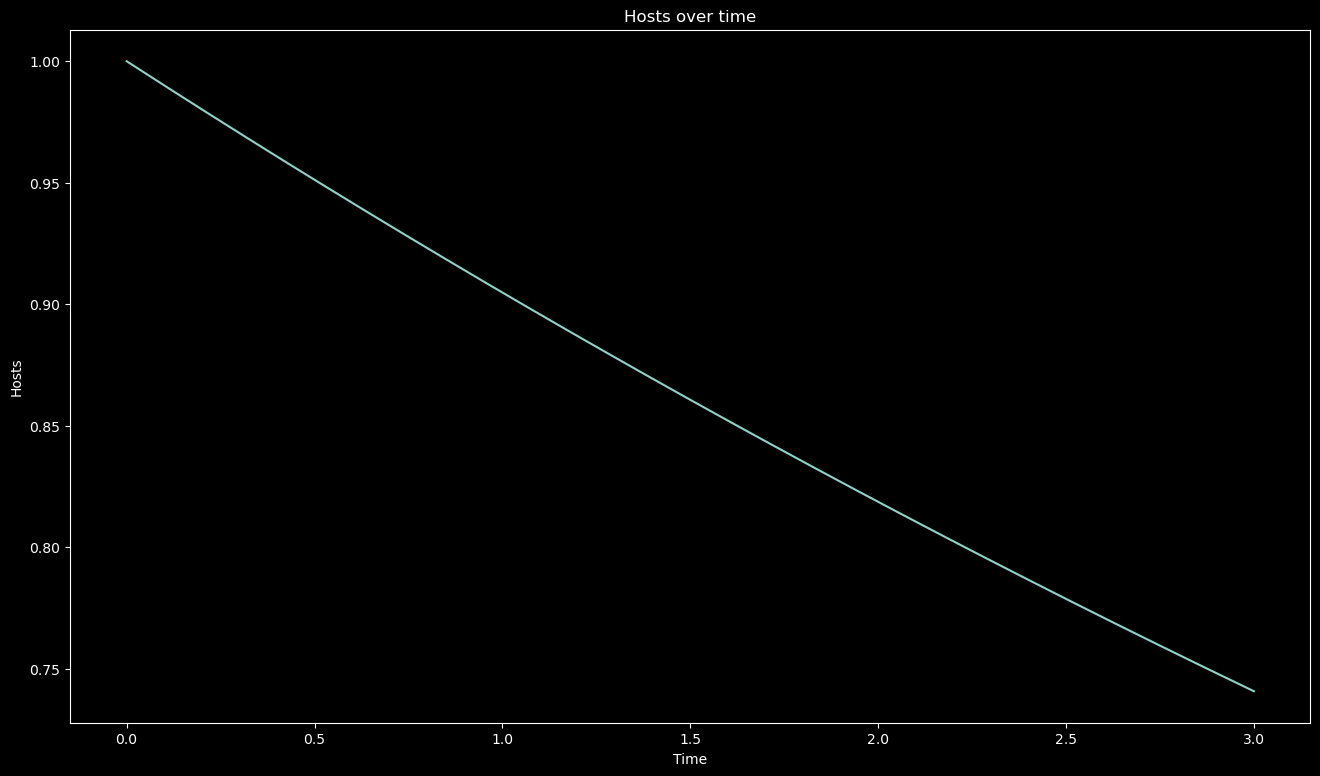

In [6]:
print(F(t).cpu().numpy().shape)
print(t.cpu().numpy().shape)
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_ft = plt.plot(t.cpu().numpy().T, F(t).cpu().numpy().T)
        plt.savefig(figureSaveDirectory + "ft_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_wtUft = wModel.plot(t, wt, title="Weight over time", xlabel="Time", ylabel="Weight", wi=[0])
        fig_wtUft.savefig(figureSaveDirectory + "wtUft_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_htUft = wModel.plot(t, ht, title="Hosts over time", xlabel="Time", ylabel="Hosts", wi=[0])
        fig_htUft.savefig(figureSaveDirectory + "htUft_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

100%|██████████| 1500/1500 [01:58<00:00, 12.64it/s, loss=-0.149, payoff=0.15, learning rate=[0.0005000000000000001]] 


Benchmark (u=0):  0.02766002155840397
Benchmark (u=0) stopped at ( 2.1763556003570557 ):  0.128157377243042
Benchmark (u=0) opt stopped at ( 1.8033373355865479 ): with price 0.14941158890724182


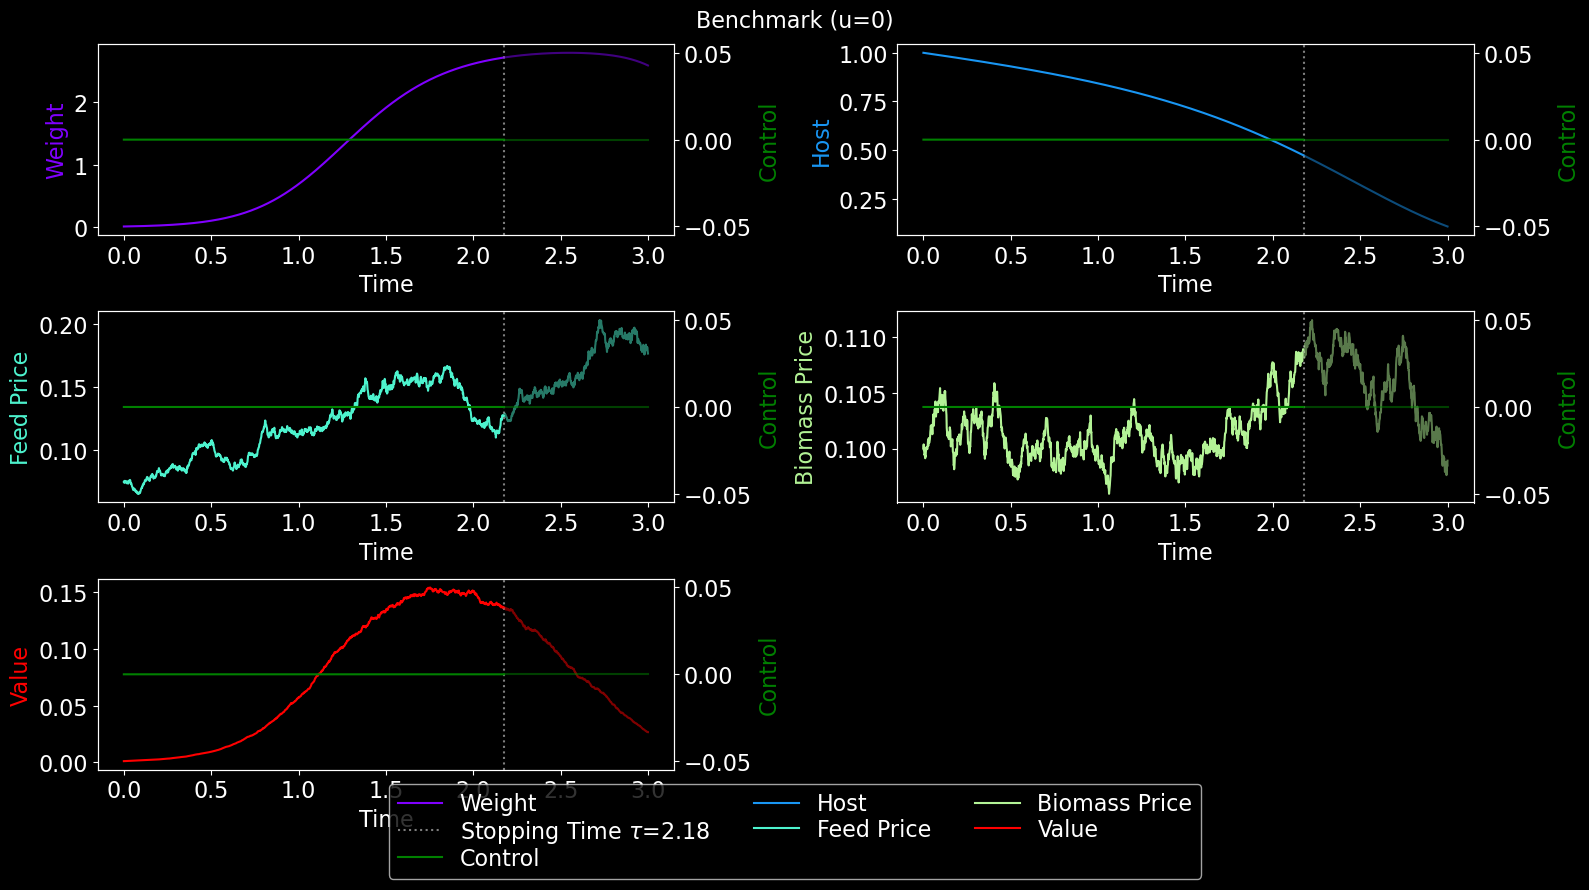

In [7]:
if Path(fileSaveDirectory + "b0.npy").is_file():
    bench_0 = torch.from_numpy(np.load(fileSaveDirectory + "b0.npy")).to(dtype=dtype, device='cpu')
else:
    bench_0, _, _ = benchmark.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=U0)
    np.save(fileSaveDirectory + "b0.npy", bench_0.cpu().numpy())

if not Path(fileSaveDirectory + "b0tau.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    def trainGen(M,batch_factor=64): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = benchmark.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=U0)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] # latent dimensions of neural network
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device)
    # print(dOS.deepOSNet)
    trainErr, trainPrice=dOS.train_loop(trainGen)


    #########################################################################
    ### Testing
    #########################################################################
    test = next(trainGen(M,batch_factor=1))
    tau,payoff=dOS.evalStopping(t_os,test)

    b0tau=np.array([tau.mean().item(),payoff.mean().item()])
    np.save(fileSaveDirectory+"b0tau.npy", b0tau)
    del dOS
else: 
    b0tau = np.load(fileSaveDirectory+"b0tau.npy")
    
print("Benchmark (u=0): ", torch.mean(bench_0[:,-1,-1]).item())
print("Benchmark (u=0) stopped at (", tau_determ.item(), "): ", torch.mean(bench_0[:,tauInd_determ,-1]).item())
print(f'Benchmark (u=0) opt stopped at ( {b0tau[0]} ): with price {b0tau[1]}')

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_b0 = plotMethod(t, bench_0, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Benchmark (u=0)")
        fig_b0.savefig(figureSaveDirectory + "b0_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()


100%|██████████| 1500/1500 [02:00<00:00, 12.47it/s, loss=-0.199, payoff=0.2, learning rate=[0.0005000000000000001]]  


Benchmark (u=F):  0.1484670341014862
Benchmark (u=F) stopped at ( 2.1763556003570557 ):  0.19741922616958618
Benchmark (u=F) opt stopped at ( 2.0247085094451904 ): with price 0.20035085082054138


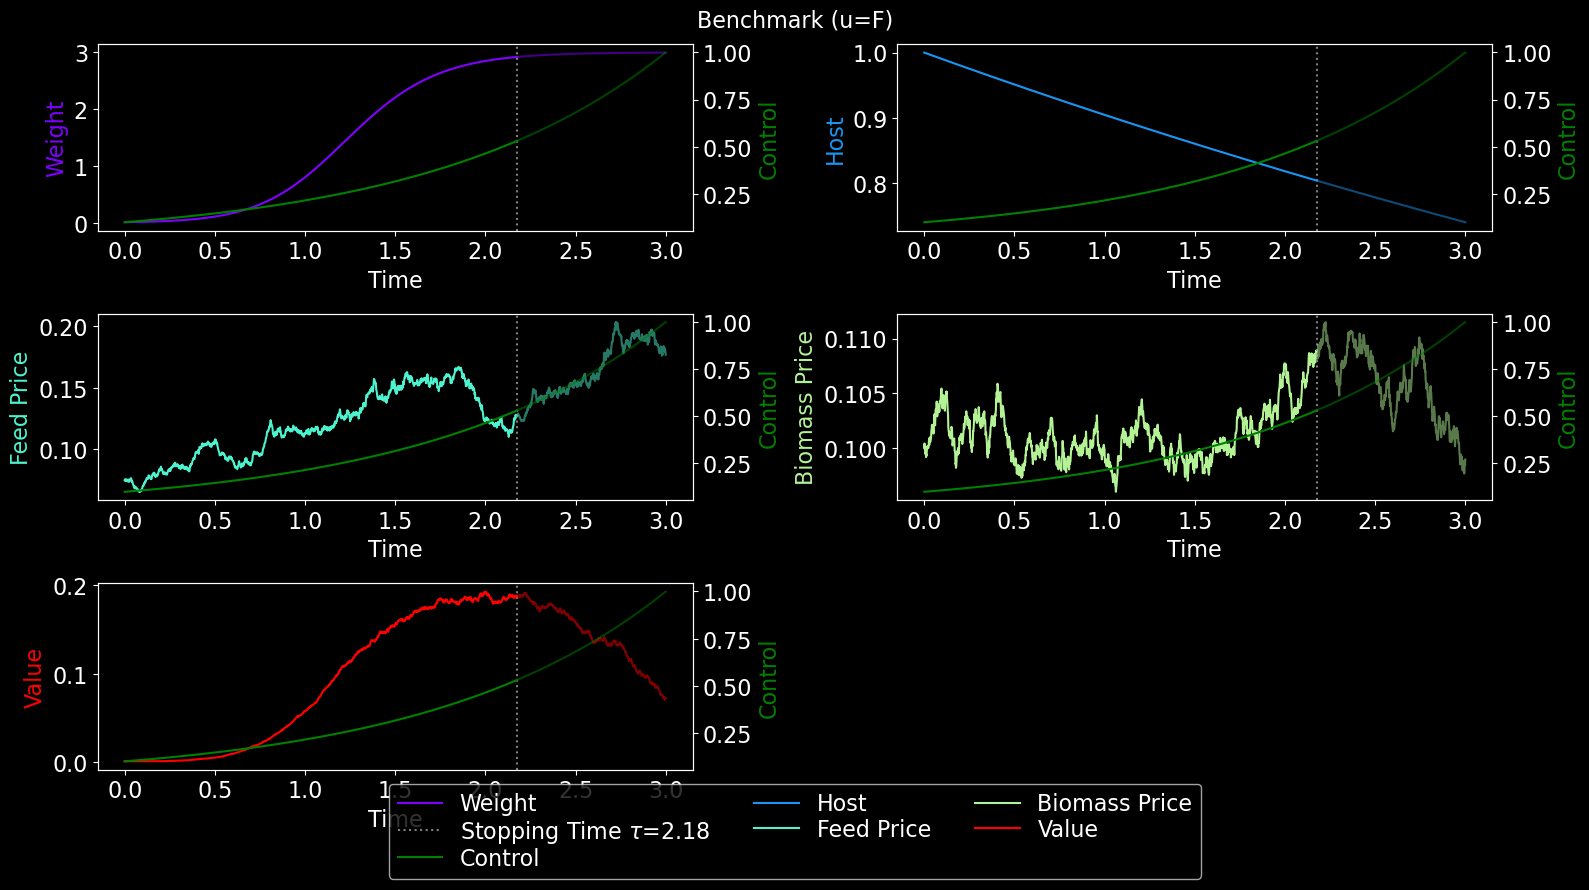

In [8]:
if Path(fileSaveDirectory + "bft.npy").is_file():
    bench_ft = torch.from_numpy(np.load(fileSaveDirectory + "bft.npy")).to(dtype=dtype, device='cpu')
else:
    bench_ft, _, _ = benchmark.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=Uft)
    np.save(fileSaveDirectory + "bft.npy", bench_ft.cpu().numpy())

if not Path(fileSaveDirectory + "bfttau.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    def trainGen(M,batch_factor=64): # You can change this and still use the same DeepOS network!
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = benchmark.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, U=Uft)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    test = next(trainGen(M,batch_factor=1))
    tau,payoff=dOS.evalStopping(t_os,test)
    bfttau=np.array([tau.mean().item(),payoff.mean().item()])
    np.save(fileSaveDirectory+"bfttau.npy", bfttau)
    del dOS
else:
    bfttau = np.load(fileSaveDirectory+"bfttau.npy")
print("Benchmark (u=F): ", torch.mean(bench_ft[:,-1,-1]).item())
print("Benchmark (u=F) stopped at (", tau_determ.item(), "): ", torch.mean(bench_ft[:,tauInd_determ,-1]).item())
print(f'Benchmark (u=F) opt stopped at ( {bfttau[0]} ): with price {bfttau[1]}')
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_bft = plotMethod(t, bench_ft, tau_determ*torch.ones((M,1),dtype=dtype,device='cpu'), tauInd_determ*torch.ones((M,1),dtype=torch.int32,device='cpu'), wi=[0], labels=labels,title="Benchmark (u=F)")
        fig_bft.savefig(figureSaveDirectory + "bft_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

In [9]:
del benchmark

## Finite-Difference Solver

In [10]:
tIndSave = torch.arange(0, Nt, 1, dtype=torch.int32, device=device)[::4]
tIndSave[-1] = Nt-1
fdSolverArgs = {'tIndSave': tIndSave}

Backward time steps: 2047it [01:40, 20.38it/s]


FD Solver (u=u^*) stopped at ( 2.0392541885375977 ):  0.2045036405324936


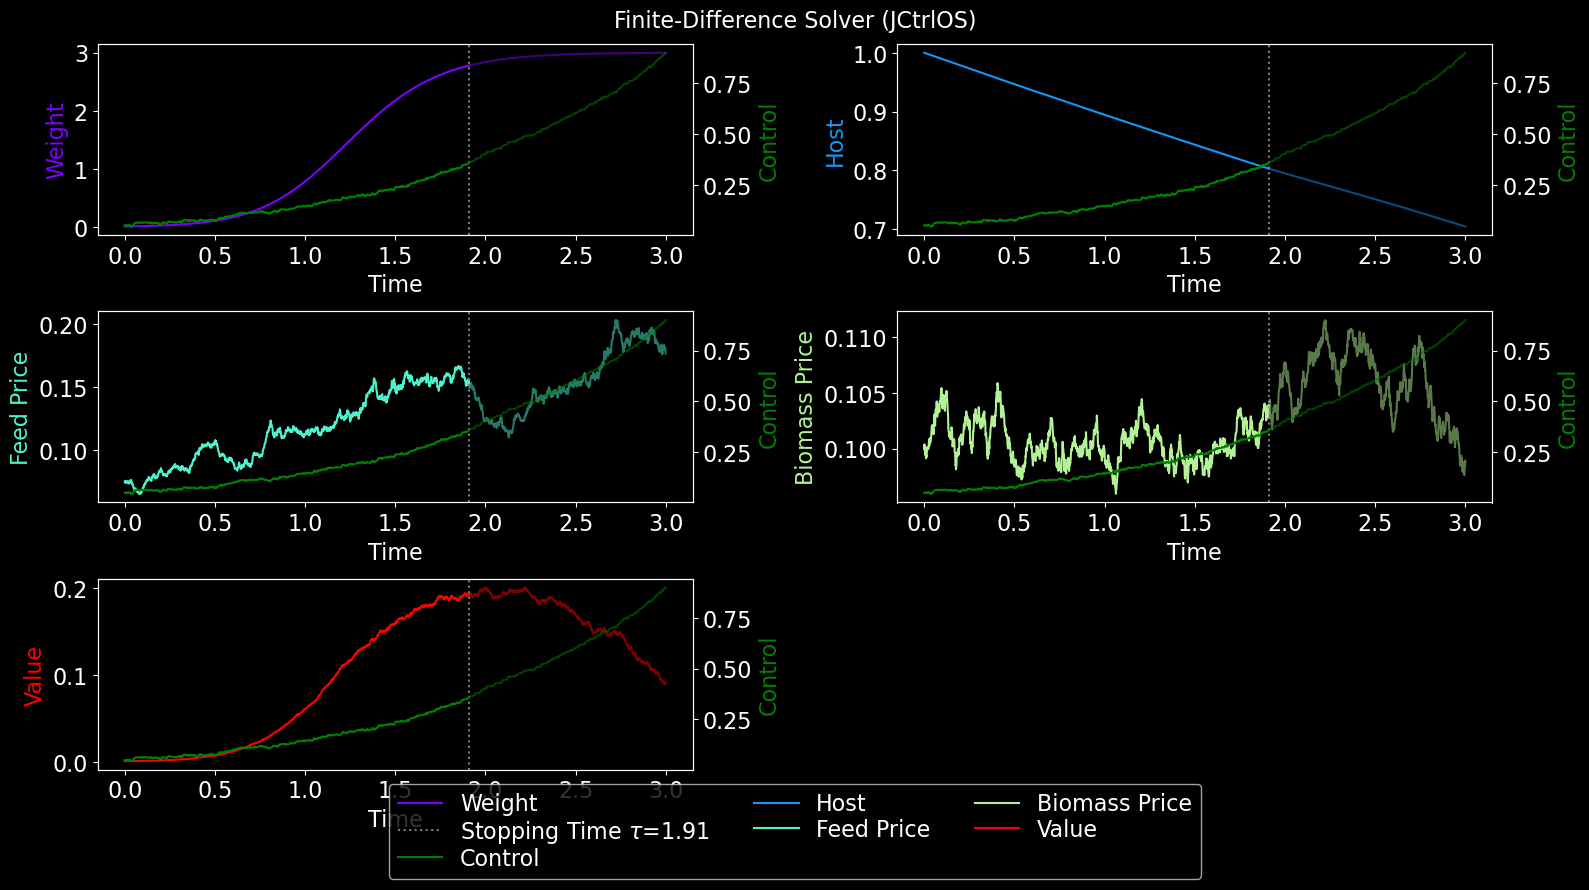

In [11]:
# %%script echo skipping # Disable cell execution
if Path(fileSaveDirectory + "fd1.npy").is_file():
    fd1 = torch.from_numpy(np.load(fileSaveDirectory + "fd1.npy")).to(dtype=dtype, device='cpu')
    tau_fd1 = torch.from_numpy(np.load(fileSaveDirectory + "tau_fd1.npy")).to(dtype=dtype, device='cpu')
    tauInd_fd1 = torch.from_numpy(np.load(fileSaveDirectory + "tauInd_fd1.npy")).to(dtype=torch.int64, device='cpu')
else:
    fdOpt1 = JointOptCtrlStopping(r, k, g, bnds, processes, FDSolver, fdSolverArgs, device=device, dtype=dtype)
    fdOpt1.solve(stopping=True)
    fd1, tau_fd1, tauInd_fd1 = fdOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    np.save(fileSaveDirectory + "fd1.npy", fd1.cpu().numpy())
    np.save(fileSaveDirectory + "tau_fd1.npy", tau_fd1.cpu().numpy())
    np.save(fileSaveDirectory + "tauInd_fd1.npy", tauInd_fd1.cpu().numpy())
    del fdOpt1

print("FD Solver (u=u^*) stopped at (", tau_fd1.mean().item(), "): ", torch.mean(torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1)).item())
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_fd1 = plotMethod(t, fd1, tau_fd1, tauInd_fd1, wi=[0], labels=labels,title="Finite-Difference Solver (JCtrlOS)")
        fig_fd1.savefig(figureSaveDirectory + "fd1_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

## Deep Solver

100%|██████████| 10000/10000 [02:28<00:00, 67.20it/s, PDE Loss=0.000642, Free BD Loss=7.08e-5, TVP Loss=9.8e-5, y<=fB=0.5, Ctrl=0.284, LR=[9.765625e-06]] 


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 2.9335875511169434 ):  0.16047383844852448
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 1.922498106956482 ):  0.20420756936073303
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.2263047695159912 ):  0.11714507639408112


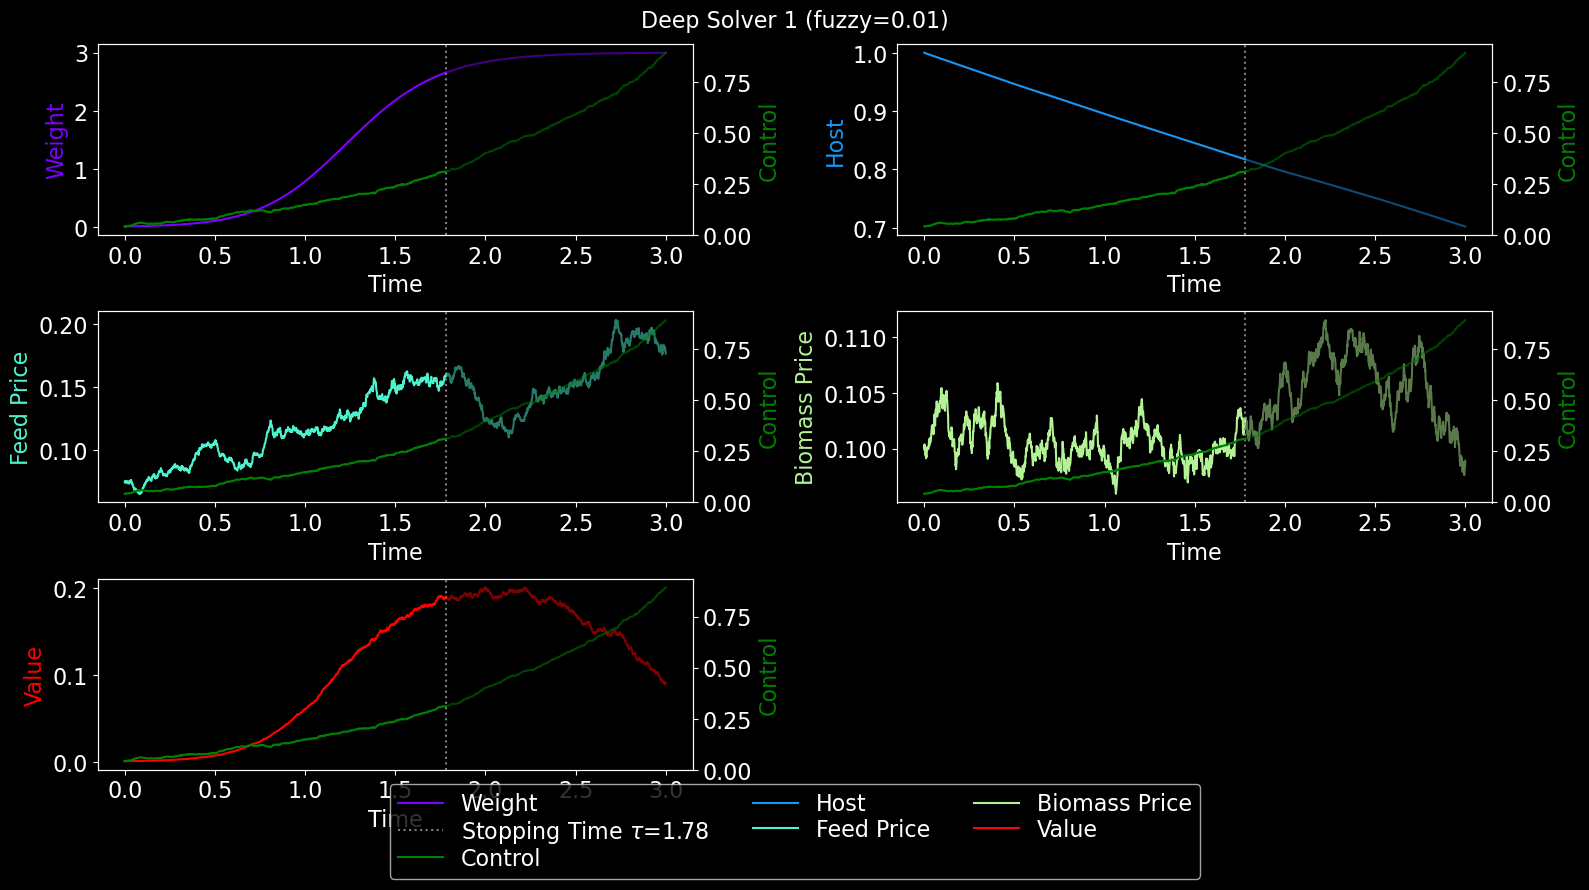

100%|██████████| 1500/1500 [02:06<00:00, 11.89it/s, loss=-0.202, payoff=0.203, learning rate=[0.0005000000000000001]]

0.2036242038011551
Deep Solver 1 (u=û) opt stopped at ( 2.0351502895355225 ): with value 0.2036242038011551 and fd error 0.000879436731338501


In [12]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+10)
torch.cuda.manual_seed_all(seed+10)
u1 = ControlProcessAquaculture({'f0':f0,'T':T,'w_inf':w_inf,'gamma_F':gamma_F,'mu_F':mu_F}, F)
dgmCell1 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell1,'u': u1, 'lr': 5e-3}
deepOpt1 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt1.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep1_tmp1, tau_deep1_tmp1, tauInd_deep1_tmp1 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp1[:,:,-1], tauInd_deep1_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep1_tmp2, tau_deep1_tmp2, tauInd_deep1_tmp2 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp2[:,:,-1], tauInd_deep1_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep1_tmp3, tau_deep1_tmp3, tauInd_deep1_tmp3 = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep1_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep1_tmp3[:,:,-1], tauInd_deep1_tmp3.unsqueeze(-1), dim=1)).item())
deep1Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep1_tmp1[:,:,-1], tauInd_deep1_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep1_tmp2[:,:,-1], tauInd_deep1_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep1_tmp3[:,:,-1], tauInd_deep1_tmp3.unsqueeze(-1), dim=1))])).item()
deep1 = [deep1_tmp1, deep1_tmp2, deep1_tmp3][deep1Ind]
tau_deep1 = [tau_deep1_tmp1, tau_deep1_tmp2, tau_deep1_tmp3][deep1Ind]
tauInd_deep1 = [tauInd_deep1_tmp1, tauInd_deep1_tmp2, tauInd_deep1_tmp3][deep1Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep1 = plotMethod(t, deep1, tau_deep1, tauInd_deep1, wi=[0], labels=labels,title="Deep Solver 1"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep1Ind])+")")
        fig_deep1.savefig(figureSaveDirectory + "deep1_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds1.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt1.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt1.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds1,payoff_ds1=dOS.evalStopping(t[:,indOS],deep1[:,indOS,:])
    tauInd_ds1 = torch.min(torch.abs(t-tau_ds1), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds1.npy", tau_ds1.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds1.npy", payoff_ds1.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds1.npy", tauInd_ds1.cpu().numpy())
    del dOS
else:
    tau_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds1.npy")).to(dtype=dtype, device=device)
    payoff_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds1.npy")).to(dtype=dtype, device=device)
    tauInd_ds1 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds1.npy")).to(dtype=torch.int64, device=device)

print(torch.take_along_dim(deep1[:,:,-1], tauInd_ds1.unsqueeze(-1), dim=1).mean().item())
print(f'Deep Solver 1 (u=û) opt stopped at ( {tau_ds1.mean().item()} ): with value {torch.take_along_dim(deep1[:,:,-1], tauInd_ds1.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep1[:,:,-1], tauInd_ds1.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt1, dgmCell1, u1

100%|██████████| 10000/10000 [04:29<00:00, 37.11it/s, PDE Loss=0.000677, Free BD Loss=8.08e-5, TVP Loss=0.000155, y<=fB=0.5, Ctrl=0.278, LR=[9.765625e-06]]


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 3.0 ):  0.15441226959228516
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 2.2406387329101562 ):  0.19884368777275085
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.2508018016815186 ):  0.12286369502544403


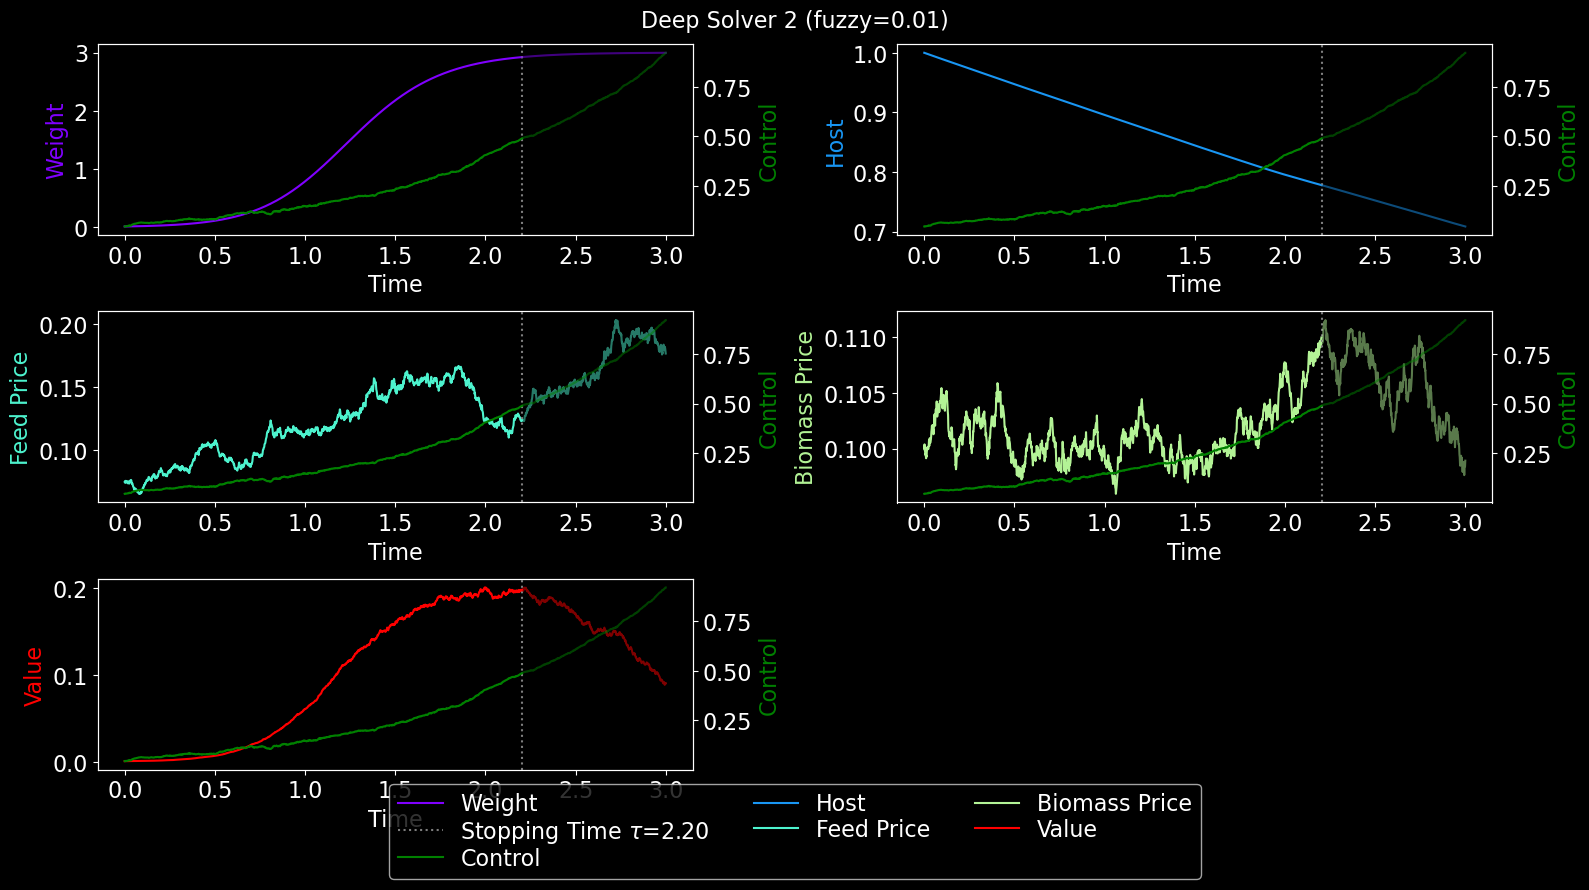

100%|██████████| 1500/1500 [02:08<00:00, 11.66it/s, loss=-0.202, payoff=0.203, learning rate=[0.0005000000000000001]]

Deep Solver 2 (u=û) opt stopped at ( 2.0376663208007812 ): with value 0.20339302718639374 and fd error 0.0011106133460998535


In [13]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+11)
torch.cuda.manual_seed_all(seed+11)
u2 = ControlProcessNN({},input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1, lr=1e-2).to(device).to(dtype)
dgmCell2 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell2,'u': u2, 'lr': 5e-3}
deepOpt2 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt2.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep2_tmp1, tau_deep2_tmp1, tauInd_deep2_tmp1 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp1[:,:,-1], tauInd_deep2_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep2_tmp2, tau_deep2_tmp2, tauInd_deep2_tmp2 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp2[:,:,-1], tauInd_deep2_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep2_tmp3, tau_deep2_tmp3, tauInd_deep2_tmp3 = deepOpt2.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep2_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep2_tmp3[:,:,-1], tauInd_deep2_tmp3.unsqueeze(-1), dim=1)).item())
deep2Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep2_tmp1[:,:,-1], tauInd_deep2_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep2_tmp2[:,:,-1], tauInd_deep2_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep2_tmp3[:,:,-1], tauInd_deep2_tmp3.unsqueeze(-1), dim=1))])).item()
deep2 = [deep2_tmp1, deep2_tmp2, deep2_tmp3][deep2Ind]
tau_deep2 = [tau_deep2_tmp1, tau_deep2_tmp2, tau_deep2_tmp3][deep2Ind]
tauInd_deep2 = [tauInd_deep2_tmp1, tauInd_deep2_tmp2, tauInd_deep2_tmp3][deep2Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep2 = plotMethod(t, deep2, tau_deep2, tauInd_deep2, wi=[0], labels=labels,title="Deep Solver 2"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep2Ind])+")")
        fig_deep2.savefig(figureSaveDirectory + "deep2_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds2.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt2.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt2.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds2,payoff_ds2=dOS.evalStopping(t[:,indOS],deep2[:,indOS,:])
    tauInd_ds2 = torch.min(torch.abs(t-tau_ds2), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds2.npy", tau_ds2.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds2.npy", payoff_ds2.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds2.npy", tauInd_ds2.cpu().numpy())
    del dOS
else:
    tau_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds2.npy")).to(dtype=dtype, device=device)
    payoff_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds2.npy")).to(dtype=dtype, device=device)
    tauInd_ds2 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds2.npy")).to(dtype=torch.int64, device=device)

print(f'Deep Solver 2 (u=û) opt stopped at ( {tau_ds2.mean().item()} ): with value {torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt2, dgmCell2, u2

100%|██████████| 10000/10000 [04:37<00:00, 36.05it/s, PDE Loss=0.000856, Free BD Loss=8.96e-5, TVP Loss=0.000152, y<=fB=0.5, Ctrl=0.275, LR=[9.765625e-06]]


Deep Solver (u=u^*) stopped with fuzzy  0.001  at ( 2.4074368476867676 ):  0.19006696343421936
Deep Solver (u=u^*) stopped with fuzzy  0.01  at ( 2.058852195739746 ):  0.20418398082256317
Deep Solver (u=u^*) stopped with fuzzy  0.1  at ( 1.2644891738891602 ):  0.12604497373104095


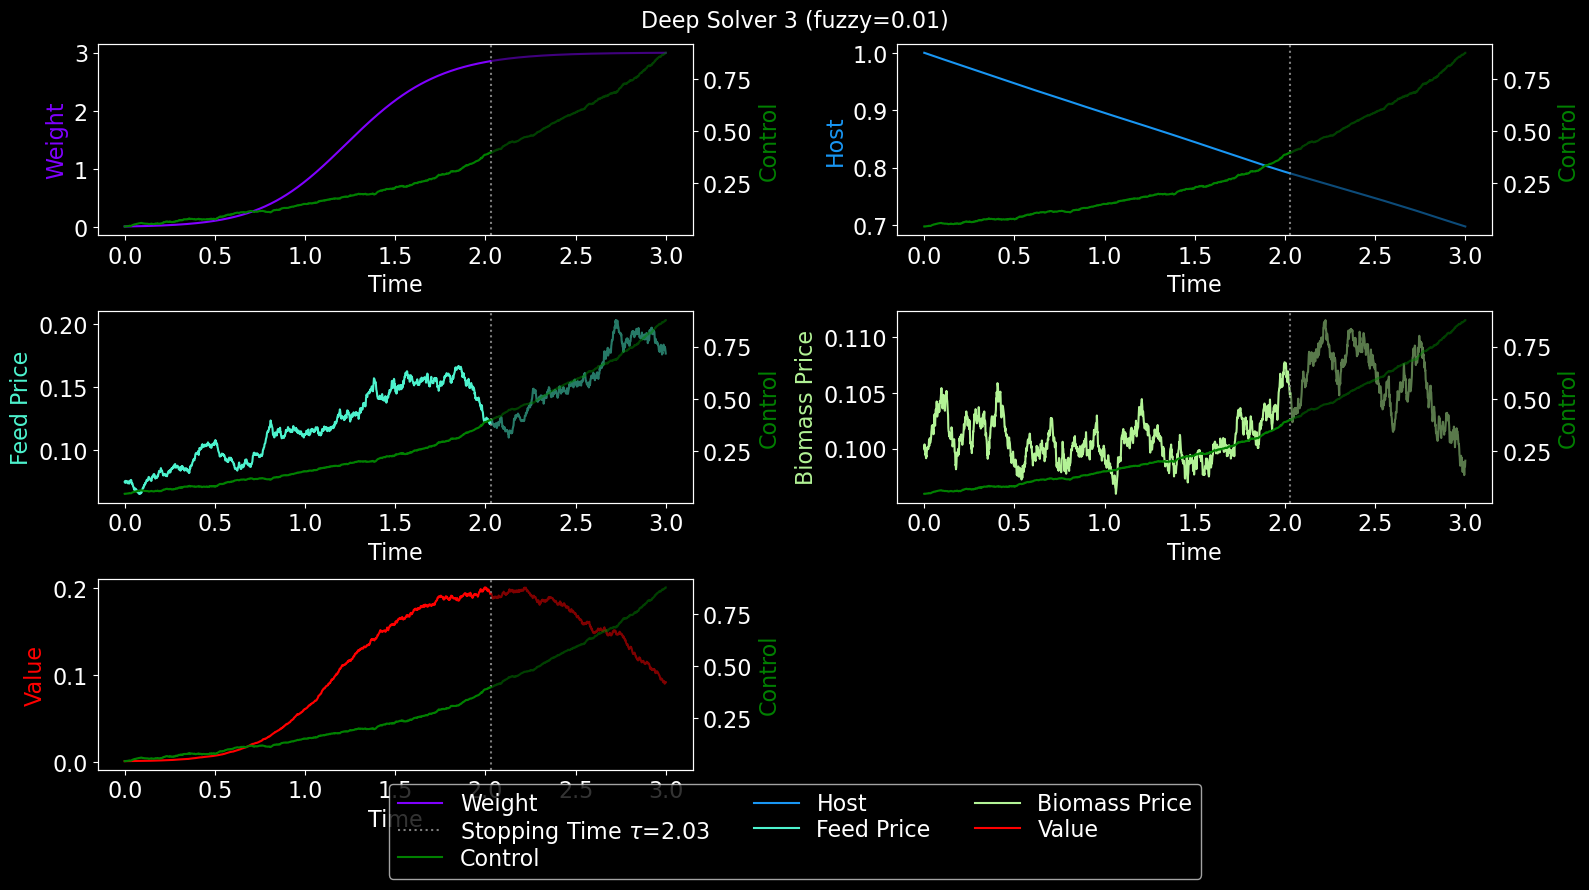

100%|██████████| 1500/1500 [02:09<00:00, 11.60it/s, loss=-0.202, payoff=0.203, learning rate=[0.0005000000000000001]]

Deep Solver 3 (u=û) opt stopped at ( 2.0377912521362305 ): with value 0.20315751433372498 and fd error 0.0013461261987686157


In [14]:
# %%script echo skipping # Disable cell execution
torch.manual_seed(seed+13)
torch.cuda.manual_seed_all(seed+13)
u3 = ControlProcessNN2({},input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1, lr=1e-2).to(device).to(dtype)
dgmCell3 = DGMCellFF(input_dim=len(bnds[:-1]), hidden_dim=32, n_layers=3, output_dim=1).to(device).to(dtype)
deepSolverArgs = {'dgmCell': dgmCell3,'u': u3, 'lr': 5e-3}
deepOpt3 = JointOptCtrlStopping(r, k, g, bnds[:-1], processes, DeepSolver, deepSolverArgs, device=device, dtype=dtype)
deepOpt3.solve(epochs=10000,batch_size=4096,stopping=True)
fuzzy = 1e-3
deep3_tmp1, tau_deep3_tmp1, tauInd_deep3_tmp1 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp1.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp1[:,:,-1], tauInd_deep3_tmp1.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-2
deep3_tmp2, tau_deep3_tmp2, tauInd_deep3_tmp2 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp2.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp2[:,:,-1], tauInd_deep3_tmp2.unsqueeze(-1), dim=1)).item())
fuzzy = 1e-1
deep3_tmp3, tau_deep3_tmp3, tauInd_deep3_tmp3 = deepOpt3.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt, fuzzy=fuzzy)
print("Deep Solver (u=u^*) stopped with fuzzy ", fuzzy ," at (", tau_deep3_tmp3.mean().item(), "): ", torch.mean(torch.take_along_dim(deep3_tmp3[:,:,-1], tauInd_deep3_tmp3.unsqueeze(-1), dim=1)).item())
deep3Ind = torch.argmax(torch.tensor([torch.mean(torch.take_along_dim(deep3_tmp1[:,:,-1], tauInd_deep3_tmp1.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep3_tmp2[:,:,-1], tauInd_deep3_tmp2.unsqueeze(-1), dim=1)), torch.mean(torch.take_along_dim(deep3_tmp3[:,:,-1], tauInd_deep3_tmp3.unsqueeze(-1), dim=1))])).item()
deep3 = [deep3_tmp1, deep3_tmp2, deep3_tmp3][deep3Ind]
tau_deep3 = [tau_deep3_tmp1, tau_deep3_tmp2, tau_deep3_tmp3][deep3Ind]
tauInd_deep3 = [tauInd_deep3_tmp1, tauInd_deep3_tmp2, tauInd_deep3_tmp3][deep3Ind]

for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        fig_deep3 = plotMethod(t, deep3, tau_deep3, tauInd_deep3, wi=[0], labels=labels,title="Deep Solver 3"+" (fuzzy="+str([1e-3,1e-2,1e-1][deep3Ind])+")")
        fig_deep3.savefig(figureSaveDirectory + "deep3_" + style + ".pdf")
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

if not Path(fileSaveDirectory + "tau_ds3.npy").is_file():
    N_os:int = int(T*128) # number of time steps, don't use too many, it will slow down the method a lot
    t_os:torch.Tensor = torch.linspace(0.0,T,N_os,dtype=dtype,device=device)

    deepOpt3.V = None
    # deep1, _, _ = deepOpt1.simulate(t, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)
    def trainGen(M,batch_factor=64):
        while True:
            dWt = BrownianMotion(t_os, M * batch_factor, dim=d, onlyIncrements=True, dtype=dtype, device=device)
            data = deepOpt3.simulate(t_os, torch.tensor([w0,h0,PF0,PB0], dtype=dtype, device=device), dWt)[0]
            for i in range(batch_factor):
                yield data[i*M:(i+1)*M,...]

    latent_dim: List[int] = [d+50,d+50] 
    dOS = DeepOSNet(d+1,N_os,latent_dim=latent_dim,outputDims=1).to(device) #d+1 because control is included
    trainErr, trainPrice=dOS.train_loop(trainGen)
    indOS = torch.argmin(torch.abs(t_os.view(-1,1) - t.view(1,-1)), dim=1)
    tau_ds3,payoff_ds3=dOS.evalStopping(t[:,indOS],deep3[:,indOS,:])
    tauInd_ds3 = torch.min(torch.abs(t-tau_ds3), dim=1, keepdim=False)[1]
    np.save(fileSaveDirectory+"tau_ds3.npy", tau_ds3.cpu().numpy())
    np.save(fileSaveDirectory+"payoff_ds3.npy", payoff_ds3.cpu().numpy())
    np.save(fileSaveDirectory+"tauInd_ds3.npy", tauInd_ds3.cpu().numpy())
    del dOS
else:
    tau_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"tau_ds3.npy")).to(dtype=dtype, device=device)
    payoff_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"payoff_ds3.npy")).to(dtype=dtype, device=device)
    tauInd_ds3 = torch.from_numpy(np.load(fileSaveDirectory+"tauInd_ds3.npy")).to(dtype=torch.int64, device=device)

print(f'Deep Solver 3 (u=û) opt stopped at ( {tau_ds3.mean().item()} ): with value {torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1).mean().item()} and fd error {np.abs(torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1).mean().item()-torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1).mean().item())}')
del deepOpt3, dgmCell3, u3

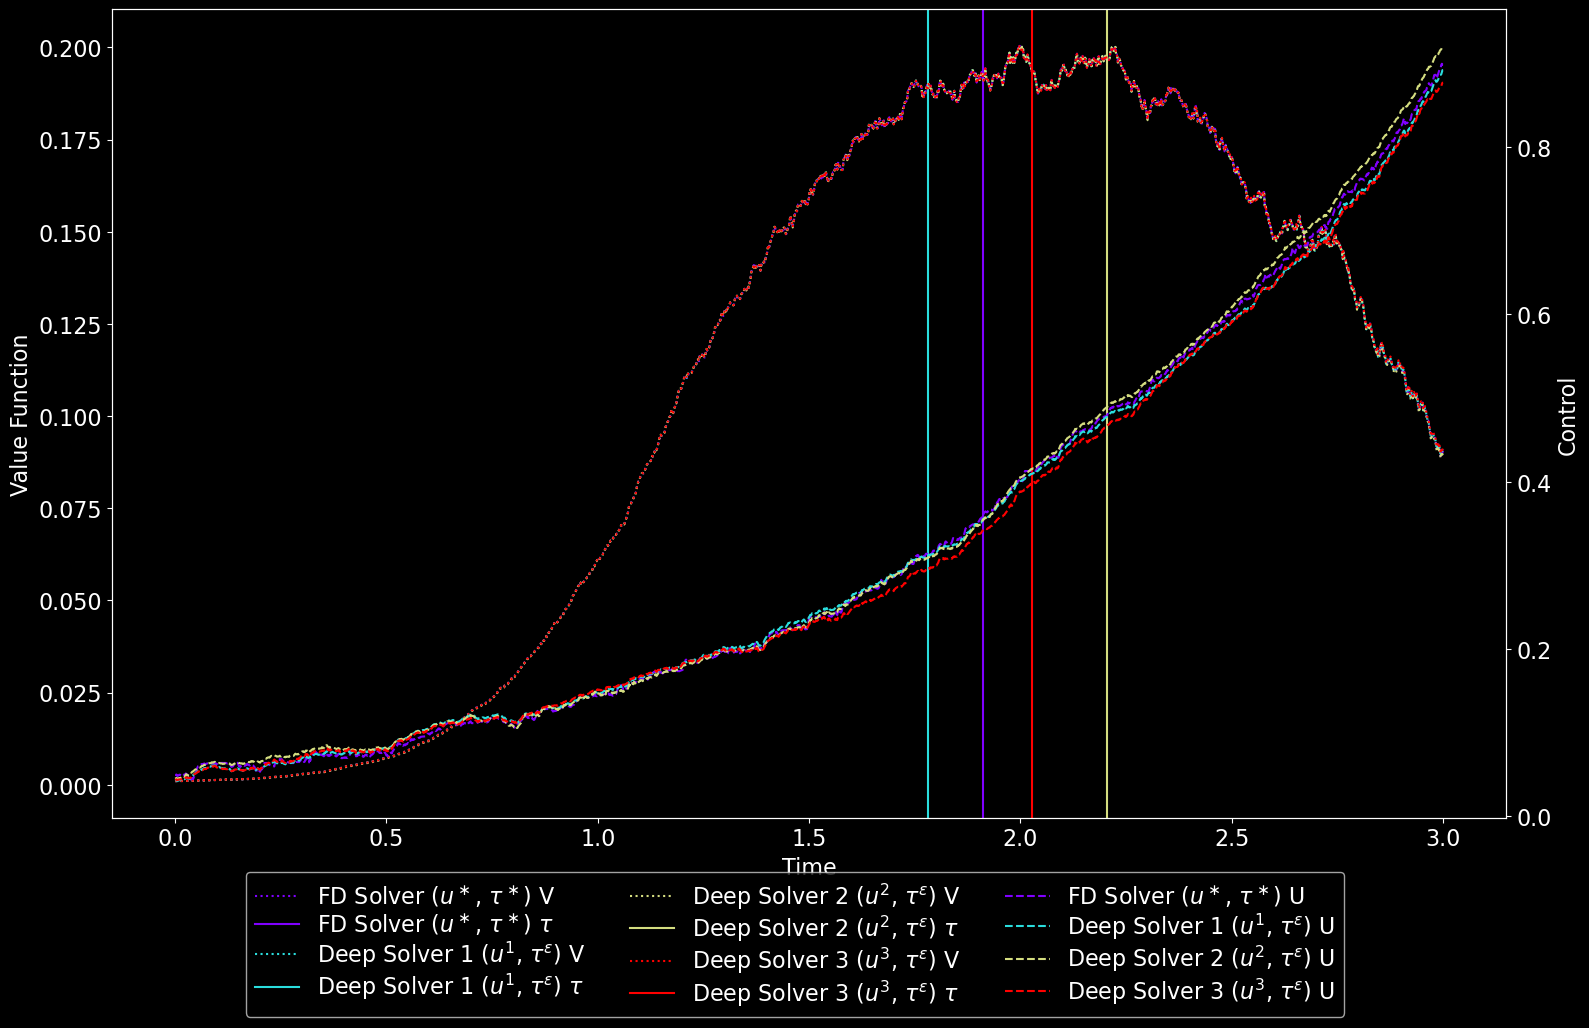

In [15]:
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        figComp=plotComparison(t, [fd1[:,:,-1], deep1[:,:,-1], deep2[:,:,-1], deep3[:,:,-1]],
                [fd1[:,:,-2], deep1[:,:,-2], deep2[:,:,-2], deep3[:,:,-2]],
                [tau_fd1.cpu(), tau_deep1.cpu(), tau_deep2.cpu(), tau_deep3.cpu()],
                wi=[0],
                labels=[r"FD Solver ($u^\ast$, $\tau^\ast$)", r"Deep Solver 1 ($u^1$, $\tau^\varepsilon$)", r"Deep Solver 2 ($u^2$, $\tau^\varepsilon$)", r"Deep Solver 3 ($u^3$, $\tau^\varepsilon$)"])
        figComp.savefig(figureSaveDirectory + "DS_comparison_" + style + ".pdf",bbox_inches='tight')
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()

In [16]:
def add_row(df, method, no_os, os, tau):
    improvement = (os / no_os - 1) * 100 if no_os != 0 else None
    return pd.concat([df, pd.DataFrame([[method, no_os/1.0, os/1.0, tau/1.0, improvement/1.0]], columns=df.columns)], ignore_index=True)
    

                                   Method  No OS     OS  $\tau$  Improvement
          Benchmark ($u=0$, $\tau$ const) 0.0277 0.1282  2.1764     363.3307
          Benchmark ($u=F$, $\tau$ const) 0.1485 0.1974  2.1764      32.9718
    FD Solver ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.2045  2.0393          NaN
Deep Solver 1 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.2042  2.0352          NaN
Deep Solver 2 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.2034  2.0377          NaN
Deep Solver 3 ($u=u^\ast$ \& $\tau^\ast$)    NaN 0.2032  2.0378          NaN


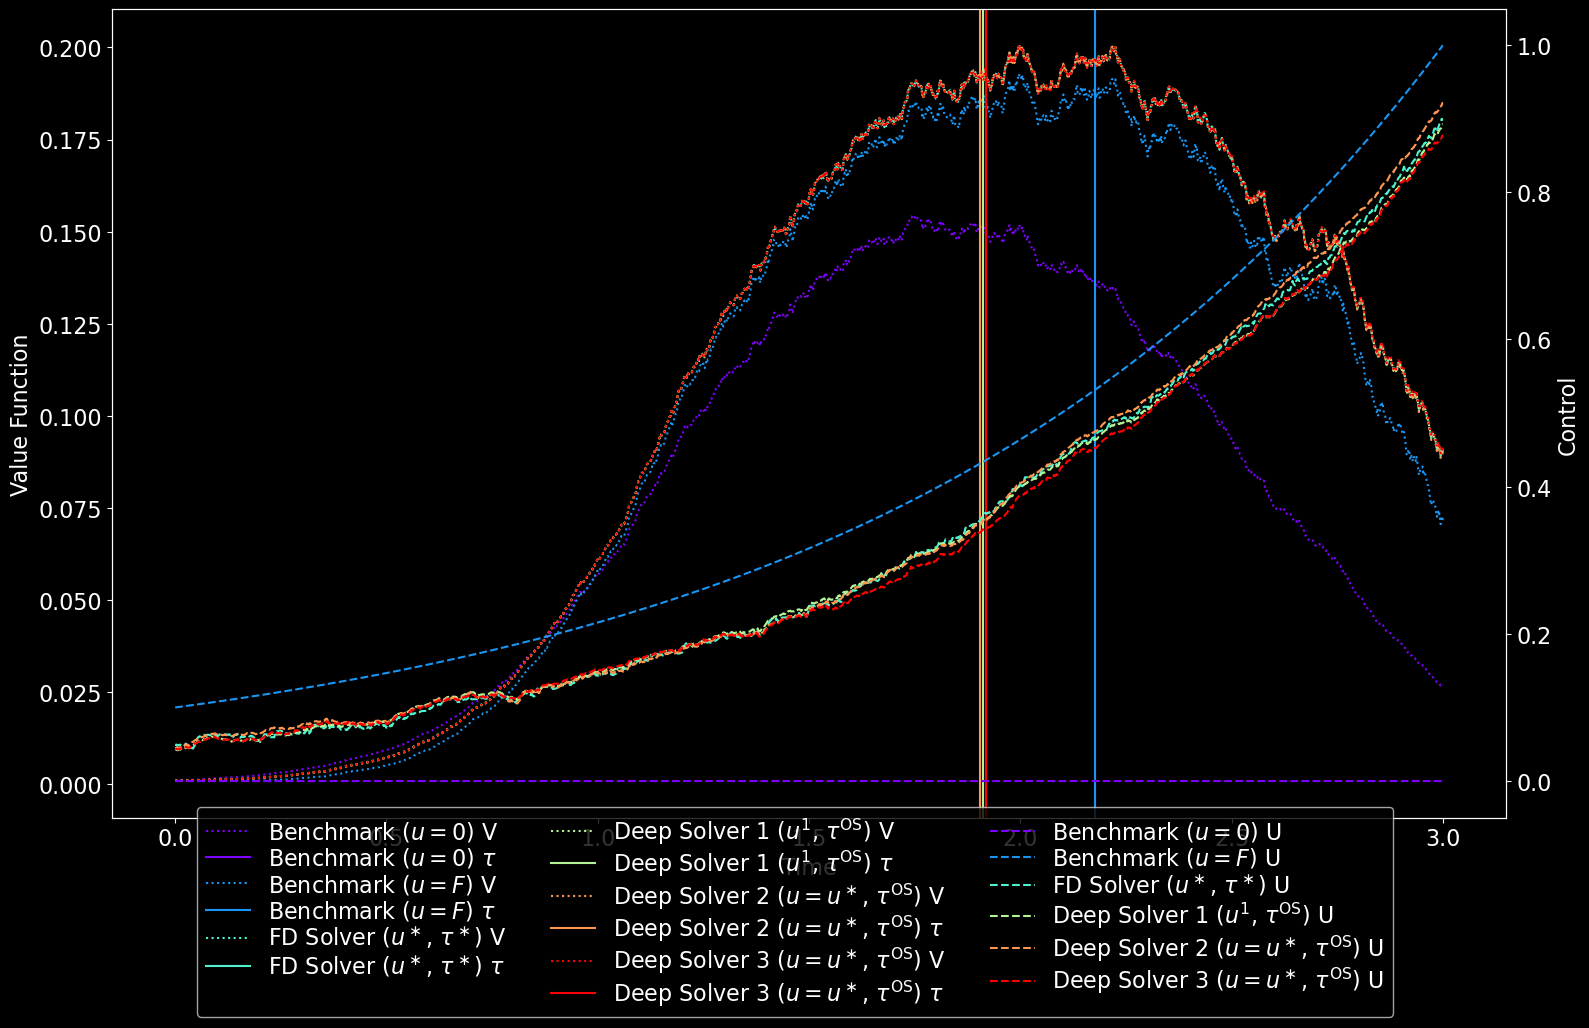

In [17]:
# Results
df = pd.DataFrame(columns=["Method", "No OS", "OS", r"$\tau$", "Improvement"])
df = add_row(df, r"Benchmark ($u=0$, $\tau$ const)", torch.mean(bench_0[:,-1,-1]).item(), torch.mean(bench_0[:,tauInd_determ,-1]).item(), tau_determ.item())
df = add_row(df, r"Benchmark ($u=F$, $\tau$ const)", torch.mean(bench_ft[:,-1,-1]).item(), torch.mean(bench_ft[:,tauInd_determ,-1]).item(), tau_determ.item())
# df = add_row(df, r"Benchmark ($u=F$, $\tau$ DOS)", torch.mean(bench_ft[:,-1,-1]).item(), torch.mean(bench_ft[:,tauInd_determ,-1]).item(), tau_determ.item()) #TODO
# df = add_row(df, r"FD Solver ($u=u^\ast$, $\tau$ const)", torch.mean(fd2[:,-1,-1]).item(), torch.mean(fd2[:,tauInd_determ,-1]).item(), tau_determ.item())
# df = add_row(df, r"FD Solver ($u=u^\ast$, $\tau$ DOS)", torch.mean(fd2[:,-1,-1]).item(), torch.mean(fd2[:,tauInd_determ,-1]).item(), tau_determ.item()) #TODO
df = add_row(df, r"FD Solver ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(fd1[:,:,-1], tauInd_fd1.unsqueeze(-1), dim=1)).item(), tau_fd1.mean().item())
df = add_row(df, r"Deep Solver 1 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep1[:,:,-1], tauInd_deep1.unsqueeze(-1), dim=1)).item(), tau_ds1.mean().item())
df = add_row(df, r"Deep Solver 2 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep2[:,:,-1], tauInd_ds2.unsqueeze(-1), dim=1)).item(), tau_ds2.mean().item())
df = add_row(df, r"Deep Solver 3 ($u=u^\ast$ \& $\tau^\ast$)", np.nan, torch.mean(torch.take_along_dim(deep3[:,:,-1], tauInd_ds3.unsqueeze(-1), dim=1)).item(), tau_ds3.mean().item())

print(df.to_string(index=False, float_format="%.4f".__mod__))
# print(df.to_latex(index=False, float_format="%.2f".__mod__, escape=False))
for i, style in enumerate(pltStyles):
    with plt.style.context(style):
        figComp=plotComparison(t, [bench_0[:,:,-1], bench_ft[:,:,-1], fd1[:,:,-1], deep1[:,:,-1], deep2[:,:,-1], deep3[:,:,-1]],
                [bench_0[:,:,-2], bench_ft[:,:,-2], fd1[:,:,-2], deep1[:,:,-2], deep2[:,:,-2], deep3[:,:,-2]],
                [tau_determ*torch.ones_like(tau_fd1.cpu()), tau_determ*torch.ones_like(tau_fd1.cpu()), tau_fd1.cpu(), tau_ds1.cpu(), tau_ds2.cpu(), tau_ds3.cpu()],
                wi=[0],
                labels=[r"Benchmark ($u=0$)", r"Benchmark ($u=F$)", r"FD Solver ($u^\ast$, $\tau^\ast$)", r"Deep Solver 1 ($u^1$, $\tau^\text{OS}$)", r"Deep Solver 2 ($u=u^\ast$, $\tau^\text{OS}$)", r"Deep Solver 3 ($u=u^\ast$, $\tau^\text{OS}$)"])
        figComp.savefig(figureSaveDirectory + "comparison_" + style + ".pdf",bbox_inches='tight')
    if i==len(pltStyles)-1:
        plt.show()
    else:
        plt.close()